<a href="https://colab.research.google.com/github/YRRbit/python-youtube-code/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
"""
读取数据集
"""
test_data = pd.read_csv('/content/drive/MyDrive/data_format1/test_format1.csv')
train_data = pd.read_csv('/content/drive/MyDrive/data_format1/train_format1.csv')

user_info = pd.read_csv('/content/drive/MyDrive/data_format1/user_info_format1.csv')
user_log = pd.read_csv('/content/drive/MyDrive/data_format1/user_log_format1.csv')

#user_info = pd.read_csv('./user_info_format1.csv').drop_duplicates()
#user_log = pd.read_csv('./user_log_format1.csv').rename(columns={"seller_id":'merchant_id'})

In [27]:
train_data.head(5)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [28]:
test_data.head(5)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [29]:
user_info.head(5)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [30]:
user_log.head(5)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [31]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [32]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


In [34]:
(user_info.shape[0]-user_info['age_range'].count())/user_info.shape[0]

0.005226677982884221

In [35]:
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()

user_id      95131
age_range    92914
gender       90664
dtype: int64

In [36]:
user_info.groupby(['age_range'])[['user_id']].count()

,user_id
age_range,
0.0,92914
1.0,24
2.0,52871
3.0,111654
4.0,79991
5.0,40777
6.0,35464
7.0,6992
8.0,1266


In [37]:
(user_info.shape[0]-user_info['gender'].count())/user_info.shape[0]

0.01517316170403376

In [38]:
user_info[user_info['gender'].isna() | (user_info['gender'] == 2)].count()

user_id      16862
age_range    14664
gender       10426
dtype: int64

In [39]:
user_info.groupby(['gender'])[['user_id']].count()

,user_id
gender,
0.0,285638
1.0,121670
2.0,10426


In [40]:
user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

In [41]:
user_info.describe()

,user_id,age_range,gender
count,424170.000000,421953.000000,417734.000000
mean,212085.500000,2.930262,0.341179
std,122447.476178,1.942978,0.524112
min,1.000000,0.000000,0.000000
25%,106043.250000,2.000000,0.000000
50%,212085.500000,3.000000,0.000000
75%,318127.750000,4.000000,1.000000
max,424170.000000,8.000000,2.000000


正负样本的数量：
 label
0    244912
1     15952
Name: user_id, dtype: int64


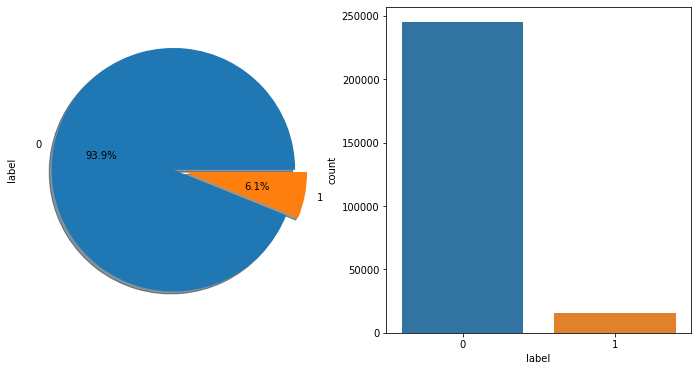

In [42]:
label_gp = train_data.groupby('label')['user_id'].count()
print('正负样本的数量：\n',label_gp)
_,axe = plt.subplots(1,2,figsize=(12,6))
train_data.label.value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,explode=[0,0.1],ax=axe[0])
sns.countplot('label',data=train_data,ax=axe[1],)

In [62]:
from numpy import *
import re

def createData(train_data):
  mat = []
  req = re.compile(r',')
  fr = open(train_data)
  content = fr.readlines()
  for line in content:
    tem = line.replace('\n','').split(',')
    mat.append(tem)
  return mat

def loadDataSet():
  return [[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], [2, 5]]

# C1 是大小为1的所有候选项集的集合
def createC1(dataSet):
  C1 = []
  for transaction in dataSet:
    for item in transaction:
      if not [item] in C1:
        C1.append([item]) #store all the item unrepeatly

  C1.sort()
  #return map(frozenset, C1)#frozen set, user can't change it.
  return list(map(frozenset, C1))

def scanD(D,Ck,minSupport):
  ssCnt={}
  for tid in D:
    for can in Ck:
      if can.issubset(tid):
        #if not ssCnt.has_key(can):
          if not can in ssCnt:
            ssCnt[can]=1
          else: ssCnt[can]+=1
  numItems=float(len(D))
  retList = []
  supportData = {}
  for key in ssCnt:
    support = ssCnt[key]/numItems   #compute support
    if support >= minSupport:
      retList.insert(0,key)
    supportData[key] = support
  return retList, supportData

#total apriori
def aprioriGen(Lk, k): #组合，向上合并
  #creates Ck 参数：频繁项集列表 Lk 与项集元素个数 k
  retList = []
  lenLk = len(Lk)
  for i in range(lenLk):
    for j in range(i+1, lenLk): #两两组合遍历
      L1 = list(Lk[i])[:k-2]; L2 = list(Lk[j])[:k-2]
      L1.sort(); L2.sort()
      if L1==L2: #若两个集合的前k-2个项相同时,则将两个集合合并
        retList.append(Lk[i] | Lk[j]) #set union
  return retList

#apriori
def apriori(dataSet, minSupport = 0.5):
  C1 = createC1(dataSet)
  D = list(map(set, dataSet)) #python3
  L1, supportData = scanD(D, C1, minSupport)#单项最小支持度判断 0.5，生成L1
  L = [L1]
  k = 2
  while (len(L[k-2]) > 0):#创建包含更大项集的更大列表,直到下一个大的项集为空
    Ck = aprioriGen(L[k-2], k)#Ck
    Lk, supK = scanD(D, Ck, minSupport)#get Lk
    supportData.update(supK)
    L.append(Lk)
    k += 1 #继续向上合并 生成项集个数更多的
  return L, supportData

#生成关联规则
# 创建关联规则
def generateRules(train_data, L, supportData, minConf=0.7):  # supportData是从scanD获得的字段
  bigRuleList = []
  for i in range(1, len(L)):  # 只获得又有2个或以上的项目的集合
    for freqSet in L[i]:
      H1 = [frozenset([item]) for item in freqSet]
      if (i > 1):
        rulesFromConseq(train_data, freqSet, H1, supportData, bigRuleList, minConf)
      else:
        calcConf(train_data, freqSet, H1, supportData, bigRuleList, minConf)
  return bigRuleList

# 实例数、支持度、置信度和提升度评估
def calcConf(train_data, freqSet, H, supportData, brl, minConf=0.7):
  prunedH = []
  D = train_data
  numItems = float(len(D))
  for conseq in H:
    conf = supportData[freqSet] / supportData[freqSet - conseq]  # 计算置信度
    if conf >= minConf:
      instances = numItems * supportData[freqSet]  # 计算实例数
      liftvalue = conf / supportData[conseq]  # 计算提升度
      brl.append((freqSet - conseq, conseq, int(instances), round(supportData[freqSet], 4), round(conf, 4),
                        round(liftvalue, 4)))  # 支持度已经在SCAND中计算得出
      prunedH.append(conseq)
  return prunedH

# 生成候选规则集
def rulesFromConseq(train_data, freqSet, H, supportData, brl, minConf=0.7):
  m = len(H[0])
  if (len(freqSet) > (m + 1)):
    Hmp1 = aprioriGen(H, m + 1)
    Hmp1 = calcConf(train_data, freqSet, Hmp1, supportData, brl, minConf)
    if (len(Hmp1) > 1):
      rulesFromConseq(train_data, freqSet, Hmp1, supportData, brl, minConf)


In [57]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5977 sha256=3ffdb32379ccd385b458443b9a5ba2c34d735f078181446c048dab95952ad7a5
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [63]:
import apyori
from apyori import apriori
#import pandas as pd 前文已引入
from graphviz import Digraph


# 设置最小支持度阈值
minS = 0.5
# 设置最小置信度阈值
minC = 0.7

data = apriori.loadDataSet()

# 计算符合最小支持度的规则
L, suppdata = apriori.apriori(data, minSupport=minS)

# 计算满足最小置信度规则
rules = apriori.generateRules(data, L, suppdata, minConf=minC)

### 关联结果评估###
model_summary = 'data record: {1} \nassociation rules count: {0}'  # 展示数据集记录数和满足阈值定义的规则数量
print (model_summary.format(len(rules), len(data)))  # 使用str.format做格式化输出
df =  pd.DataFrame(rules,  columns=['item1',  'itme2',  'instance',  'support',
    'confidence', 'lift'])  # 创建频繁规则数据框
df_lift = df[df['lift'] > 1.0]  # 只选择提升度>1的规则
df_lift.sort_values('instance', ascending=False)

AttributeError: ignored

选取top5店铺
店铺	购买次数
4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64


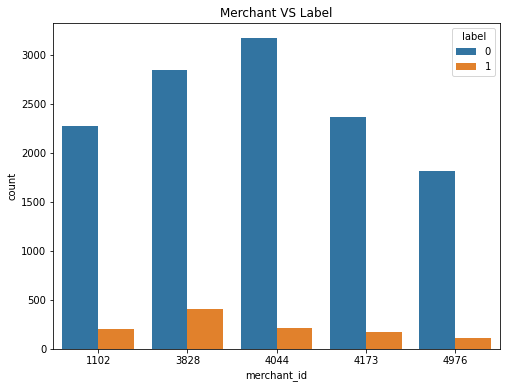

In [43]:
print('选取top5店铺\n店铺\t购买次数')
print(train_data.merchant_id.value_counts().head(5))
train_data_merchant = train_data.copy()
train_data_merchant['TOP5'] = train_data_merchant['merchant_id'].map(lambda x: 1 if x in [4044,3828,4173,1102,4976] else 0)
train_data_merchant = train_data_merchant[train_data_merchant['TOP5']==1]
plt.figure(figsize=(8,6))
plt.title('Merchant VS Label')
ax = sns.countplot('merchant_id',hue='label',data=train_data_merchant)
for p in ax.patches:
    height = p.get_height()

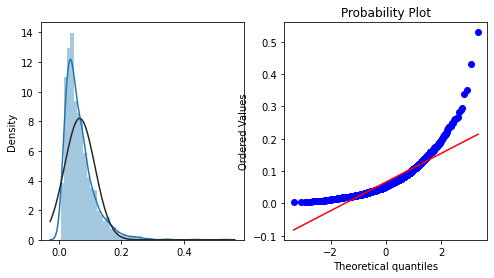

In [44]:
merchant_repeat_buy = [ rate for rate in train_data.groupby(['merchant_id'])['label'].mean() if rate <= 1 and rate > 0] 
plt.figure(figsize=(8,4))

ax=plt.subplot(1,2,1)
sns.distplot(merchant_repeat_buy, fit=stats.norm)
ax=plt.subplot(1,2,2)
res = stats.probplot(merchant_repeat_buy, plot=plt)

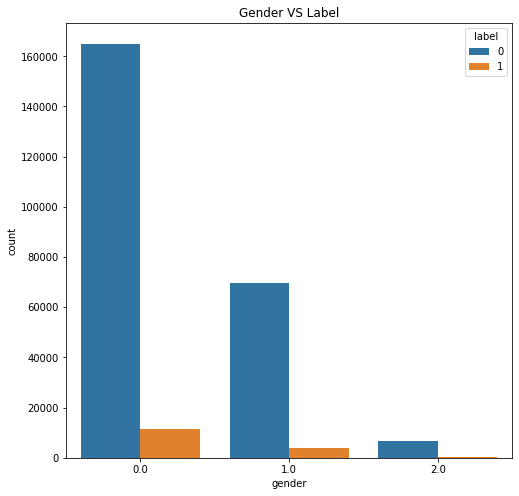

In [47]:
train_data_user_info = train_data.merge(user_info,on=['user_id'],how='left')
plt.figure(figsize=(8,8))
plt.title('Gender VS Label')
ax = sns.countplot('gender',hue='label',data = train_data_user_info)
for p in ax.patches:
    height = p.get_height()

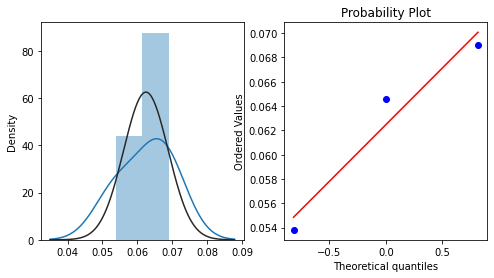

In [48]:
repeat_buy = [rate for rate in train_data_user_info.groupby(['gender'])['label'].mean()] 

plt.figure(figsize=(8,4))

ax=plt.subplot(1,2,1)
sns.distplot(repeat_buy, fit=stats.norm)
ax=plt.subplot(1,2,2)
res = stats.probplot(repeat_buy, plot=plt)

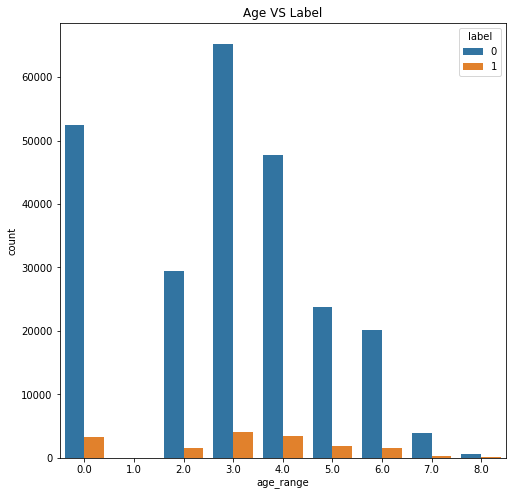

In [49]:
plt.figure(figsize=(8,8))
plt.title('Age VS Label')
ax = sns.countplot('age_range',hue='label',data=train_data_user_info)

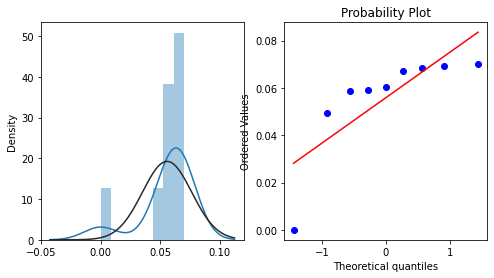

In [50]:
repeat_buy = [rate for rate in train_data_user_info.groupby(['age_range'])['label'].mean()] 

plt.figure(figsize=(8,4))

ax=plt.subplot(1,2,1)
sns.distplot(repeat_buy, fit=stats.norm)
ax=plt.subplot(1,2,2)
res = stats.probplot(repeat_buy, plot=plt)